# *Relaxation and Decoherence* 

This notebook provides a method of running circuits and measuring hardware parameters of the $T_1$ and $T_2$ decay times for 2 connected qubits. The method of parameter extraction is through solving a Markovian quantum master equation and minimising the least-squares regression between this solution and the experimental data. The notebook is split into two main segments, the experimental circuits and collection of data, followed by the numerical solutions.

## Initialisation Cell

In [1]:
# Plotting
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

# Numerical
import jax
import numpy as np
import scipy
import jax.numpy as jnp
import jax.scipy as jsp

from jax.numpy import linalg
from jax.numpy.linalg import multi_dot
from jax import grad, jit, vmap, pmap, random, jacfwd, jacrev
# from jax.ops import index, index_add, index_update
from jax.experimental.ode import odeint
from numpy import nanargmin, nanargmax
from numpy import sqrt

# key = random.PRNGKey(42)

# Qiskit
import qiskit

from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, IBMQ
from qiskit.compiler import transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.tools.visualization import *
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import U1Gate, U2Gate
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
# from qiskit_experiments.library import LocalReadoutError, CorrelatedReadoutError

provider = IBMQ.load_account()

# Constants and Units
from astropy import units as unts
from astropy import constants as cnts

# Extras
import smtplib, ssl
import warnings

warnings.filterwarnings("ignore")

# Shows a window in the upper left part with real-time information 
# on the status of the jobs running on the IBM Q device
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [2]:
jax.local_devices()

[CpuDevice(id=0)]

## Connect to IBMQ

In [3]:
IBMQ.get_provider(hub='ibm-q',
                  group='open',
                  project='main')
backend = provider.get_backend('ibmq_santiago')


Initialise our parameters

In [4]:
t1l = []
t2l = []

for i in range(len(backend.properties().qubits)):
    t1l.append(backend.properties().t1(i))
    t2l.append(backend.properties().t2(i))

In [5]:
q0err = backend.properties().readout_error(0)
print(q0err)
# q1err = backend.properties().readout_error(1)
# print(q1err)

0.03839999999999999


In [6]:
backend_config = backend.configuration()
backend_prop = backend.properties()

hamiltonian = backend_config.hamiltonian
w0 = hamiltonian['vars']['wq2']
# w1 = hamiltonian['vars']['wq1']
# w2 = hamiltonian['vars']['wq2']
# w3 = hamiltonian['vars']['wq3']
# w4 = hamiltonian['vars']['wq4']
# j01 = hamiltonian['vars']['jq0q1']
# j12 = hamiltonian['vars']['jq1q2']
# j23 = hamiltonian['vars']['jq2q3']
# j34 = hamiltonian['vars']['jq3q4']

In [7]:
ygate_time = (backend.properties().gate_length('sx', 0) * 2 * unts.s).to(unts.ns)
ygate_time

<Quantity 71.11111111 ns>

In [8]:
# qerr = np.sqrt(q0err ** 2 + q1err ** 2) / 2
# qerr

In [9]:
xgate_time = (backend.properties().gate_length('x', 0) * unts.s).to(unts.ns)
xgate_time

<Quantity 35.55555556 ns>

In [10]:
qiskit.circuit.library.YGate(0).decompositions[0].draw()

┌───────────────┐
q_0: ┤ U3(π,π/2,π/2) ├
     └───────────────┘

In [11]:
qiskit.circuit.library.U3Gate(np.pi, np.pi/2, np.pi/2).decompositions[0].draw()

/home/dean/.local/lib/python3.9/site-packages/qiskit/circuit/tools/pi_check.py:55: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = expr.expr_free_symbols


┌─────────┐┌────┐┌────────┐┌────┐┌──────────┐
q_0: ┤ Rz(π/2) ├┤ √X ├┤ Rz(2π) ├┤ √X ├┤ Rz(7π/2) ├
     └─────────┘└────┘└────────┘└────┘└──────────┘

In [12]:
(backend.properties().gate_length('rz', 0) * unts.s).to(unts.ns)

<Quantity 0. ns>

In [13]:
qiskit.circuit.library.U2Gate(0, 0).decompositions[0].draw()

┌─────────────┐
q_0: ┤ U3(π/2,0,0) ├
     └─────────────┘

In [14]:
qiskit.circuit.library.U3Gate(np.pi/2, 0, 0).decompositions[0].draw()

global phase: 3π/2
     ┌───────┐┌────┐┌──────────┐┌────┐┌────────┐
q_0: ┤ Rz(0) ├┤ √X ├┤ Rz(3π/2) ├┤ √X ├┤ Rz(3π) ├
     └───────┘└────┘└──────────┘└────┘└────────┘

In [15]:
t2gatetime = 3 * ygate_time
t2gatetime.to(unts.us)

<Quantity 0.21333333 us>

With some helper functions

In [16]:
def expt(T, w):
    """
    This function computes the average number of photons, n, depending on the frequency, w, and the temperature, T.
    Inputs:
    T - Temperature (in Kelvin)
    w - Frequency (in Hz)
    Outputs:
    n - Average photon number
    """
    n = 1/(np.exp((cnts.hbar.value * w)/(cnts.k_B.value * T)) - 1)
    return float(n)

In [17]:
def T(w, n):
    """
    This function computes the temperature, T, depending on the frequency, w, and the average number of photons, n.
    Inputs:
    T - Temperature (in Kelvin)
    n - Average photon number
    Outputs:
    w - Frequency (in Hz)
    """
    return cnts.hbar.value * w/(cnts.k_B.value * jnp.log(1/n + 1)) * unts.K

As well as some ansatze for the other parameters, based on the latest configuration $T_1$ & $T_2$ times and the claimed qubit temperatures of 15 mK.

In [18]:
n1 = expt(15e-3, w0)
# n2 = expt(15e-3, w1)

t1c = jnp.array(t1l)
t2c = jnp.array(t2l)

g1l = 1/t1c
g2l = 1/t2c

## Generation of coherence circuits

This shows how to generate the circuits. The list of qubits specifies for which qubits to generate characterization circuits; these circuits will run in parallel. The discrete unit of time is the Delay gate, which instructs the circuit to do nothing for a specified amount of time.

In [19]:
time = np.linspace(0, 74*4, 75)
tie = np.linspace(0, 74, 75)

qubits = [2]
shots = 8192

n = len(qubits)
N = 2 ** n

qr = qiskit.QuantumRegister(max(qubits)+1)
cr = qiskit.ClassicalRegister(len(qubits))

nosc = 5

osc_freq = nosc/time[-1]

In [20]:
cool = pl.cm.cool(np.linspace(0, 1, N))
plasma = pl.cm.plasma(np.linspace(0, 1, N + 1))
magma = pl.cm.magma(np.linspace(0, 1, N))
winter = pl.cm.winter(np.linspace(0, 1, N))

In [21]:
def pad_id_gates(circuit, qr, qubit, num_of_id_gates):
    """
    A function for padding a circuit with single-qubit delay gates.
    Args:
        circuit (QuantumCircuit): the quantum circuit that the gates should be
            appended to
        qr (QuantumRegister): the qubit register where the gates should be added
        qubit (int): index of qubit where the gates should be added
        num_of_id_gates (int): the number of delay gates to add
    Returns:
        circuit: The original circuit object, but with delay
            gates added to the qubit register qr at qubit 'qubit'
    """
    
    circuit.barrier(qr[qubit])
    num_of_id_gates = int(num_of_id_gates)
    circuit.delay(num_of_id_gates, qr[qubit], unit = 'us')

    circuit.barrier(qr[qubit])
    return circuit

### T1 Circuits

In [22]:
t1circuits = []

for circ_index, circ_length in enumerate(time):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't1circuit_' + str(circ_index) + '_0'
    for _, qubit in enumerate(qubits):
        circ.x(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t1circuits.append(circ)

In [23]:
t1circuits[-1].draw()

░    
q0_0: ──────────────────────────────░────
                                    ░    
q0_1: ──────────────────────────────░────
      ┌───┐ ░ ┌────────────────┐ ░  ░ ┌─┐
q0_2: ┤ X ├─░─┤ Delay(296[us]) ├─░──░─┤M├
      └───┘ ░ └────────────────┘ ░  ░ └╥┘
c0: 1/═════════════════════════════════╩═
                                       0

### T2* Circuits

In [24]:
t2scircuits = []

for circ_index, circ_length in enumerate(tie * 4):
    circ = qiskit.QuantumCircuit(qr, cr)
    circ.name = 't2starcircuit_' + str(circ_index) + '_0'
    for qind, qubit in enumerate(qubits):
        circ.h(qr[qubit])
        circ = pad_id_gates(circ, qr, qubit, circ_length)
        circ.append(U1Gate(2*np.pi*osc_freq*time[circ_index]), [qr[qubit]])
        circ.h(qr[qubit])
    circ.barrier(qr)
    for qind, qubit in enumerate(qubits):
        circ.measure(qr[qubit], cr[qind])
    t2scircuits.append(circ)

In [25]:
t2scircuits[-1].draw()

░    
q0_0: ──────────────────────────────────────────────░────
                                                    ░    
q0_1: ──────────────────────────────────────────────░────
      ┌───┐ ░ ┌────────────────┐ ░ ┌─────────┐┌───┐ ░ ┌─┐
q0_2: ┤ H ├─░─┤ Delay(296[us]) ├─░─┤ U1(10π) ├┤ H ├─░─┤M├
      └───┘ ░ └────────────────┘ ░ └─────────┘└───┘ ░ └╥┘
c0: 1/═════════════════════════════════════════════════╩═
                                                       0

### T2 Circuits

In [26]:
def t2_circuits(time, qubits, n_echos, phase_alt_echo):
    
    if n_echos < 1:
        raise ValueError('Must be at least one echo')

    xdata = 2 * np.array(time) * n_echos

    qr = qiskit.QuantumRegister(max(qubits)+1)
    cr = qiskit.ClassicalRegister(len(qubits))

    circuits = []

    for circ_index, circ_length in enumerate(time):
        circ = qiskit.QuantumCircuit(qr, cr)
        circ.name = 't2circuit_' + str(circ_index) + '_0'
        for qind, qubit in enumerate(qubits):

            # First Y90 and Y echo
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.y(qr[qubit])

            for echoid in range(n_echos-1):  # repeat
                circ = pad_id_gates(circ, qr, qubit, 2*circ_length)  # ids
                if phase_alt_echo and (not echoid % 2):  # optionally
                    circ.x(qr[qubit])  # X
                else:
                    circ.y(qr[qubit])

            circ = pad_id_gates(circ, qr, qubit, circ_length)  # ids
            circ.append(U2Gate(0.0, 0.0), [qr[qubit]])  # Y90
        circ.barrier(qr)
        for qind, qubit in enumerate(qubits):
            circ.measure(qr[qubit], cr[qind])  # measure
        circuits.append(circ)

    return circuits

In [27]:
# CPMG Circuits
t2ccircuits = t2_circuits(np.floor(time).astype(int), qubits, n_echos = 2, phase_alt_echo = True)
# Echo Circuits
t2ecircuits = t2_circuits(np.floor(time).astype(int), qubits, n_echos = 1, phase_alt_echo = False)

In [28]:
t2ccircuits[-1].draw()

»
q1_0: ────────────────────────────────────────────────────────────────────────»
                                                                              »
q1_1: ────────────────────────────────────────────────────────────────────────»
      ┌─────────┐ ░ ┌────────────────┐ ░ ┌───┐ ░ ┌────────────────┐ ░ ┌───┐ ░ »
q1_2: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(592[us]) ├─░─┤ X ├─░─»
      └─────────┘ ░ └────────────────┘ ░ └───┘ ░ └────────────────┘ ░ └───┘ ░ »
c1: 1/════════════════════════════════════════════════════════════════════════»
                                                                              »
«                                       ░    
«q1_0: ─────────────────────────────────░────
«                                       ░    
«q1_1: ─────────────────────────────────░────
«      ┌────────────────┐ ░ ┌─────────┐ ░ ┌─┐
«q1_2: ┤ Delay(296[us]) ├─░─┤ U2(0,0) ├─░─┤M├
«      └────────────────┘ ░ └─────────┘ ░ └╥┘
«c1: 1/════════════════════════════════════╩═
«                                          0

In [29]:
t2ecircuits[-1].draw()

»
q2_0: ────────────────────────────────────────────────────────────────»
                                                                      »
q2_1: ────────────────────────────────────────────────────────────────»
      ┌─────────┐ ░ ┌────────────────┐ ░ ┌───┐ ░ ┌────────────────┐ ░ »
q2_2: ┤ U2(0,0) ├─░─┤ Delay(296[us]) ├─░─┤ Y ├─░─┤ Delay(296[us]) ├─░─»
      └─────────┘ ░ └────────────────┘ ░ └───┘ ░ └────────────────┘ ░ »
c2: 1/════════════════════════════════════════════════════════════════»
                                                                      »
«                  ░    
«q2_0: ────────────░────
«                  ░    
«q2_1: ────────────░────
«      ┌─────────┐ ░ ┌─┐
«q2_2: ┤ U2(0,0) ├─░─┤M├
«      └─────────┘ ░ └╥┘
«c2: 1/═══════════════╩═
«                     0

### Readout Error Mitigation

In [30]:
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubits, qr=qr, circlabel='mcal')

## Backend Execution

In [31]:
# Run the Readout Error Mitigation circuits
cal_results = qiskit.execute(meas_calibs, backend = backend, shots = shots).result()
# cal_results = backend.retrieve_job('628b8a1eff7757f7f254d7a0').result()


In [32]:
# Run the T1 circuits
t1_backend_result = qiskit.execute(t1circuits, backend, shots = shots, optimization_level = 0).result()
# t1_backend_result = backend.retrieve_job('628b8c3c158b8b2b4a9453fa').result()


In [33]:
# Run the T2* circuits
t2star_backend_result = qiskit.execute(t2scircuits, backend, shots = shots, optimization_level = 0).result()
# t2star_backend_result = backend.retrieve_job(
#     '628b90e2158b8bdeaa94541d').result()


In [34]:
# Run the T2 Echo circuits
t2e_backend_result = qiskit.execute(t2ecircuits, backend, shots = shots, optimization_level = 0).result()
# t2e_backend_result = backend.retrieve_job('628b9612ff77571c8054d809').result()


In [35]:
# Run the T2 CPMG circuits
# t2c_backend_result = qiskit.execute(t2ccircuits, backend, shots = shots, optimization_level = 0).result()

Let's look at the calibration results

Average Measurement Fidelity: 0.966675


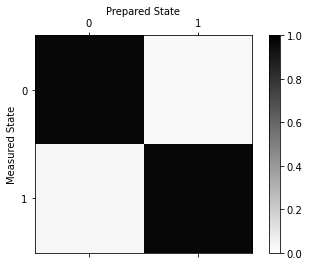

In [36]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel = 'mcal')
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())
meas_fitter.plot_calibration()

Apply the error mitigation

In [37]:
# Results without mitigation
t1_raw_counts = t1_backend_result.get_counts(0)
t2s_raw_counts = t2star_backend_result.get_counts(0)
t2e_raw_counts = t2e_backend_result.get_counts(0)
# t2c_raw_counts = t2c_backend_result.get_counts(0)

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation

t1_mitigated_results = meas_filter.apply(t1_backend_result)
t2s_mitigated_results = meas_filter.apply(t2star_backend_result)
t2e_mitigated_results = meas_filter.apply(t2e_backend_result)
# t2c_mitigated_results = meas_filter.apply(t2c_backend_result)

t1_mitigated_counts = t1_mitigated_results.get_counts(0)
t2s_mitigated_counts = t2s_mitigated_results.get_counts(0)
t2e_mitigated_counts = t2e_mitigated_results.get_counts(0)
# t2c_mitigated_counts = t2c_mitigated_results.get_counts(0)

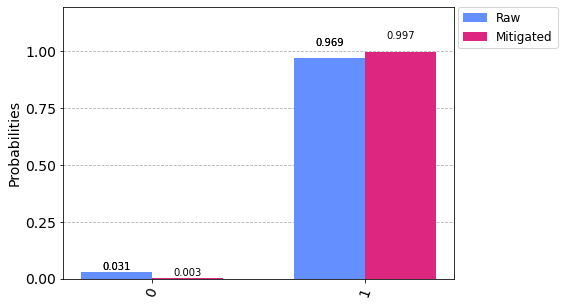

In [38]:
# T1 Mitigated Counts
plot_histogram([t1_raw_counts, t1_mitigated_counts], legend = ['Raw', 'Mitigated'])

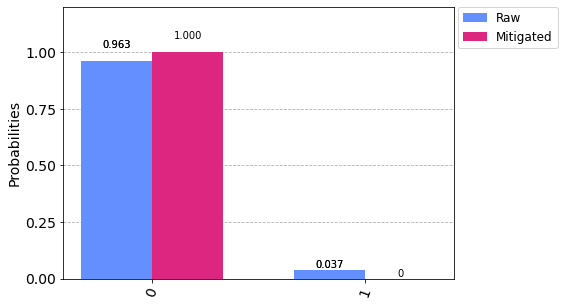

In [39]:
# T2* Mitigated Counts
plot_histogram([t2s_raw_counts, t2s_mitigated_counts], legend = ['Raw', 'Mitigated'])

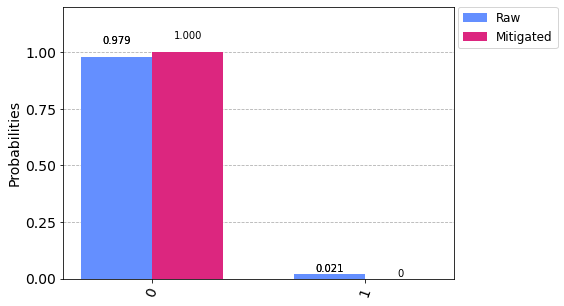

In [40]:
# T2 Echo Mitigated Counts
plot_histogram([t2e_raw_counts, t2e_mitigated_counts], legend = ['Raw', 'Mitigated'])

In [41]:
# T2 CPMG Mitigated Counts
# plot_histogram([t2c_raw_counts, t2c_mitigated_counts], legend = ['Raw', 'Mitigated'])

## Data Fitting

In [42]:
# T1 Raw

t1raw_lst0 = []
t1raw_lst1 = []

t1ystd0 = []
t1ystd1 = []

for i in range(len(time)):
    if '1' in t1_backend_result.get_counts(i):
        i1 = t1_backend_result.get_counts(i)['1']
    else:
        i1 = 0
    if '0' in t1_backend_result.get_counts(i):
        i0 = t1_backend_result.get_counts(i)['0']
    else:
        i0 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t1ystd0.append(np.sqrt(q0 * (1-q0) / shots) + (2 * q0err * q0))
    # t1ystd1.append(np.sqrt(q1 * (1-q1) / shots) + (2 * q1err * q1))
    
    t1raw_lst0.append(q0)
    t1raw_lst1.append(q1)

In [43]:
# T1 Mitigated

t1mit_lst0 = []
t1mit_lst1 = []

for i in range(len(time)):
    if '1' in t1_mitigated_results.get_counts(i):
        i1 = t1_mitigated_results.get_counts(i)['1']
    else:
        i1 = 0
    if '0' in t1_mitigated_results.get_counts(i):
        i0 = t1_mitigated_results.get_counts(i)['0']
    else:
        i0 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t1mit_lst0.append(q0)
    t1mit_lst1.append(q1)

In [44]:
# T2* Raw

t2sraw_lst0 = []
t2sraw_lst1 = []

for i in range(len(time)):
    if '0' in t2star_backend_result.get_counts(i):
        i0 = t2star_backend_result.get_counts(i)['0']
    else:
        i0 = 0
    if '1' in t2star_backend_result.get_counts(i):
        i1 = t2star_backend_result.get_counts(i)['1']
    else:
        i1 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t2sraw_lst0.append(q0)
    t2sraw_lst1.append(q1)

In [45]:
# T2* Mitigated

t2smit_lst0 = []
t2smit_lst1 = []

for i in range(len(time)):
    if '0' in t2s_mitigated_results.get_counts(i):
        i0 = t2s_mitigated_results.get_counts(i)['0']
    else:
        i0 = 0
    if '1' in t2s_mitigated_results.get_counts(i):
        i1 = t2s_mitigated_results.get_counts(i)['1']
    else:
        i1 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t2smit_lst0.append(q0)
    t2smit_lst1.append(q1)

In [46]:
# T2E Raw

t2eraw_lst0 = []
t2eraw_lst1 = []

for i in range(len(time)):
    if '0' in t2e_backend_result.get_counts(i):
        i0 = t2e_backend_result.get_counts(i)['0']
    else:
        i0 = 0
    if '1' in t2e_backend_result.get_counts(i):
        i1 = t2e_backend_result.get_counts(i)['1']
    else:
        i1 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t2eraw_lst0.append(q0)
    t2eraw_lst1.append(q1)

In [47]:
# T2E Mitigated

t2emit_lst0 = []
t2emit_lst1 = []

for i in range(len(time)):
    if '0' in t2e_mitigated_results.get_counts(i):
        i0 = t2e_mitigated_results.get_counts(i)['0']
    else:
        i0 = 0
    if '1' in t2e_mitigated_results.get_counts(i):
        i1 = t2e_mitigated_results.get_counts(i)['1']
    else:
        i1 = 0
    
    q0 = i0/shots
    q1 = i1/shots
    
    t2emit_lst0.append(q0)
    t2emit_lst1.append(q1)

In [48]:
# T2 CPMG Raw

# t2craw_lst0 = []
# t2craw_lst1 = []

# for i in range(len(time)):
#     if '0' in t2c_backend_result.get_counts(i):
#         i0 = t2c_backend_result.get_counts(i)['0']
#     else:
#         i0 = 0
#     if '1' in t2c_backend_result.get_counts(i):
#         i1 = t2c_backend_result.get_counts(i)['1']
#     else:
#         i1 = 0
    
#     q0 = i0/shots
#     q1 = i1/shots
    
#     t2craw_lst0.append(q0)
#     t2craw_lst1.append(q1)

In [49]:
# T2 CPMG Mitigated

# t2cmit_lst0 = []
# t2cmit_lst1 = []

# for i in range(len(time)):
#     if '0' in t2c_mitigated_results.get_counts(i):
#         i0 = t2c_mitigated_results.get_counts(i)['0']
#     else:
#         i0 = 0
#     if '1' in t2c_mitigated_results.get_counts(i):
#         i1 = t2c_mitigated_results.get_counts(i)['1']
#     else:
#         i1 = 0
    
#     q0 = i0/shots
#     q1 = i1/shots
    
#     t2cmit_lst0.append(q0)
#     t2cmit_lst1.append(q1)

## Plot the $T_1$ Results

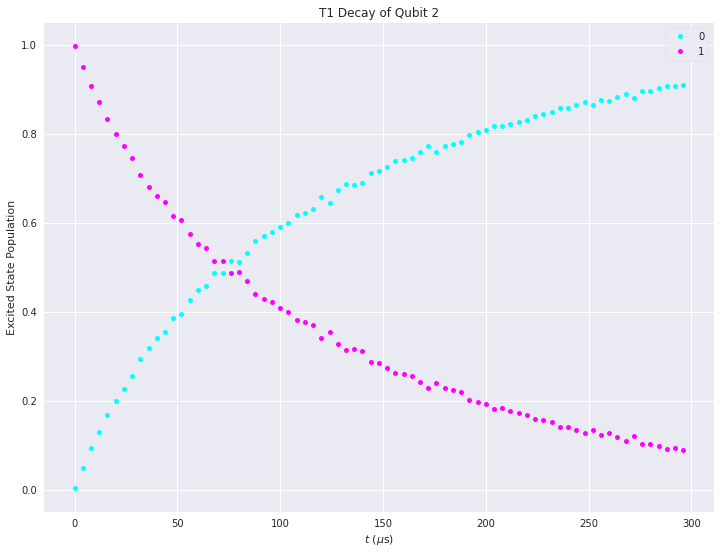

In [50]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T1 Decay of Qubit ' + str(qubits[0]))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)

plt.errorbar(time, t1mit_lst0, label = "0", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst1, label = "1", marker='.', markersize=10, linestyle='', c = cool[1])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2^*$ Results

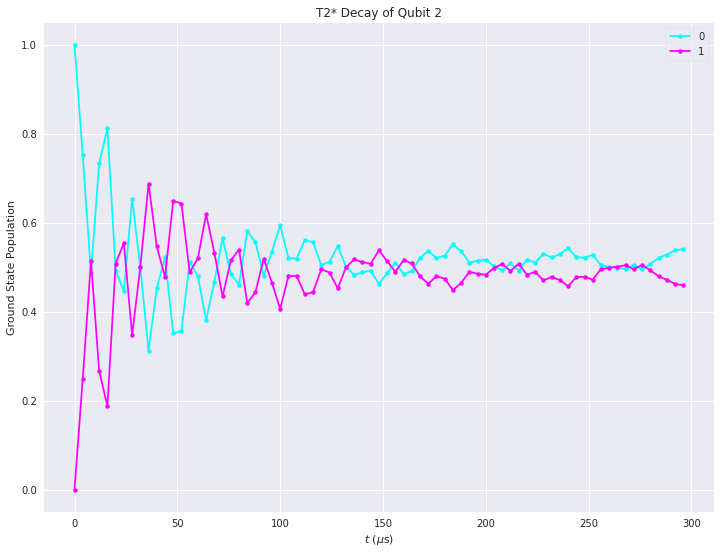

In [51]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2* Decay of Qubit ' + str(qubits[0]))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2smit_lst0, label = "0", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2smit_lst1, label = "1", marker='.', markersize=9, c = cool[1])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ Echo Results

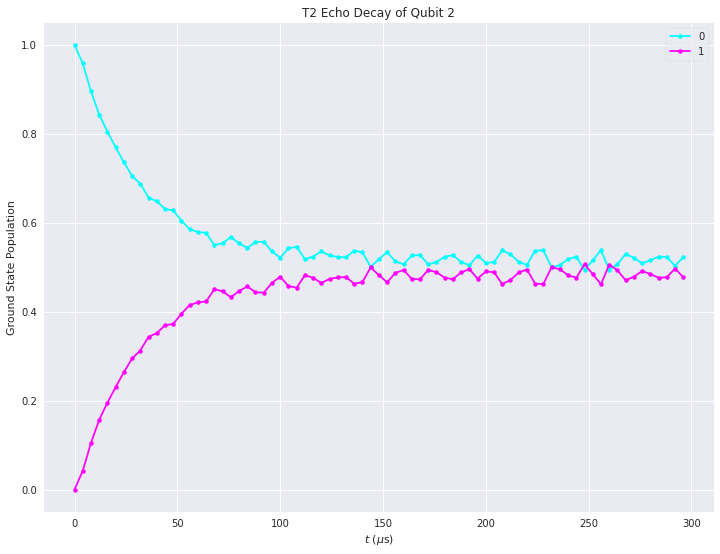

In [52]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.title('T2 Echo Decay of Qubit ' + str(qubits[0]))
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Ground State Population')
plt.ylim(-0.05, 1.05)

plt.plot(time, t2emit_lst0, label = "0", marker='.', markersize=9, c = cool[0])
plt.plot(time, t2emit_lst1, label = "1", marker='.', markersize=9, c = cool[1])

plt.legend(loc = "best", numpoints = 1, frameon = True)
    
plt.show()

## Plot the $T_2$ CPMG Results

In [53]:
# %matplotlib inline
# plt.style.use('seaborn')
# # matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
# fig, ax = plt.subplots(figsize=(12, 9))

# plt.title('T2 Echo Decay of Qubit ' + str(qubits[0]))
# plt.xlabel('$t$ ($\mu$s)')
# plt.ylabel('Ground State Population')
# plt.ylim(-0.05, 1.05)

# plt.plot(time, t2cmit_lst0, label = "0", marker='.', markersize=9, c = cool[0])
# plt.plot(time, t2cmit_lst1, label = "1", marker='.', markersize=9, c = cool[1])

# plt.legend(loc = "best", numpoints = 1, frameon = True)
    
# plt.show()

# Numerical Solutions

In [54]:
1/np.sqrt(2) * jnp.array([1, 1], dtype=jnp.complex64)

DeviceArray([0.70710677+0.j, 0.70710677+0.j], dtype=complex64)

In [55]:
sz = jnp.array([[1,0],[0,-1]], dtype = jnp.complex64)
sx = jnp.array([[0,1],[1,0]], dtype = jnp.complex64)
sy = jnp.array([[0, -1j],[1j, 0]], dtype = jnp.complex64)

sp = jnp.array([[0,1],[0,0]], dtype = jnp.complex64)
sm = jnp.array([[0,0],[1,0]], dtype = jnp.complex64)

zero = jnp.array([1, 0], dtype = jnp.complex64)
one = jnp.array([0, 1], dtype = jnp.complex64)
plus = 1/np.sqrt(2) * jnp.array([1, 1], dtype=jnp.complex64)
minus = 1/np.sqrt(2) * jnp.array([1, -1], dtype = jnp.complex64)
right = 1/np.sqrt(2) * (zero + 1j * one)
left = 1/np.sqrt(2) * (zero - 1j * one)

id2 = jnp.identity(2, dtype = jnp.complex64)
id4 = jnp.kron(id2, id2)

sz1 = jnp.kron(sz, id2)
sx1 = jnp.kron(sx, id2)
sy1 = jnp.kron(sy, id2)
sp1 = jnp.kron(sp, id2)
sm1 = jnp.kron(sm, id2)

sz2 = jnp.kron(id2, sz)
sx2 = jnp.kron(id2, sx)
sy2 = jnp.kron(id2, sy)
sp2 = jnp.kron(id2, sp)
sm2 = jnp.kron(id2, sm)

O1 = (jnp.identity(4) - sz1)/2
O2 = (jnp.identity(4) - sz2)/2

H2 = 1/jnp.sqrt(2) * jnp.array([[1, 1],
                                [1, -1]], dtype = jnp.complex64)

H4 = np.kron(H2, H2)

def ugate(t, p, l):
    u = jnp.array([[jnp.cos(t/2), - jnp.exp(1j * l) * jnp.sin(t/2)],
                  [jnp.exp(1j * p) * jnp.sin(t/2), jnp.exp(1j * (p + l)) * jnp.cos(t/2)]], dtype = jnp.complex64)
    return u

def u1gate(l):
    u = jnp.array([[1, 0],
                  [0, jnp.exp(1j * l)]], dtype = jnp.complex64)
    return u

def u2gate(p, l):
    u = 1/jnp.sqrt(2) * jnp.array([[1, -jnp.exp(1j * l)],
                                   [jnp.exp(1j * p), jnp.exp(1j * (p + l))]], dtype = jnp.complex64)
    return u

def dagger(A):
    return jnp.transpose(jnp.conjugate(A))

Y90 = jnp.kron(u2gate(0, 0), u2gate(0, 0))

X = jnp.kron(sx, sx)
Y = jnp.kron(sy, sy)

xdata = time / 1e6

We will solve the following equation. The Quantum Master equation for a two-qubit system undergoing thermal relaxation and decoherence:
$$\frac{d \rho}{dt}=\mathcal{L}\rho,$$
where
$$\mathcal{L}\rho =-\imath[H,\rho]+\gamma(\langle n \rangle +1)\left(\sigma_-\rho\sigma_++\frac{1}{2}\left\{\sigma_+\sigma_-,\rho\right\}\right) + \gamma(\langle n \rangle)\left(\sigma_+\rho\sigma_-+\frac{1}{2}\left\{\sigma_-\sigma_+,\rho\right\}\right) + \gamma_z \left( \sigma_z \rho \sigma_z - \rho \right)$$

and
$$
H = \frac{\omega_1}{2}\sigma_x + \frac{\omega_2}{2}\sigma_y + \frac{\omega_2}{2}\sigma_z
$$

$$
\langle n \rangle=\frac{1}{e^{\hbar\omega/kT}-1}
$$

The initial condition of the $T_1$ solution is:
$$\rho(0)=|0\rangle\langle 0|,$$
where 
$$|0\rangle=\left(\begin{matrix}
1\\
0
\end{matrix}\right)$$

$$
\rho_0 = \begin{pmatrix}
1 & 0 \\
0 & 0 \\
\end{pmatrix}
$$

In [56]:
init = jnp.array(jnp.outer(plus, plus), dtype = jnp.complex64)

inio = jnp.array(jnp.outer(zero, zero), dtype = jnp.complex64)

ini1 = jnp.array(jnp.outer(one, one), dtype = jnp.complex64)

# inim = jnp.array(jnp.outer(jnp.kron(minus, minus), jnp.kron(minus, minus)), dtype = jnp.complex64)

# inid = jnp.array(jnp.outer(jnp.kron(plus, minus), jnp.kron(plus, minus)), dtype = jnp.complex64)

# inip = jnp.array(jnp.outer(jnp.kron(minus, plus), jnp.kron(minus, plus)), dtype = jnp.complex64)

# iniP = jnp.array(jnp.outer(jnp.kron(plus, plus), jnp.kron(minus, minus)), dtype = jnp.complex64)

# inir = jnp.array(jnp.outer(jnp.kron(right, right), jnp.kron(right, right)), dtype = jnp.complex64)

# inil = jnp.array(jnp.outer(jnp.kron(left, left), jnp.kron(left, left)), dtype = jnp.complex64)

# inix = jnp.diag(jnp.array([0.25, 0.25, 0.25, 0.25]))

In [57]:
xdata = time / 1e6
xd = time/1e3
qtime = jnp.linspace(0, 0.075, 75)
# prmsl = [w0, w1, g1l[0], g1l[1], j01, n1, n2]
# prms1 = jnp.array([w0, w1, g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([w0, w1, 6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2e = jnp.array([w0, w1, g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

# prms1 = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01, n1, n2]) / 1e9
# prms2s = jnp.array([6 * g2l[0] * 1e6, 6 * g2l[1] * 1e6, j01, n1, n2]) / 1e9
# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9
# prms2e = jnp.array([g2l[0] * 1e6, g2l[1] * 1e6, j01, n1, n2]) / 1e9

# prms_t1 = jnp.array([w0, w0, w0, g1l[0] * 1e6, g1l[0] * 1e6, n1]) / 1e9
prms_t1 = jnp.array([w0, w0, w0, g1l[0] * 1e6, 0, n1]) / 1e9
prms_t2s = jnp.array([0, 0, w0 * 6, g2l[0] * 1e6 * 5, 0, n1]) / 1e9

## Define the Master Equation Solvers

In [58]:
# Function for the T1 Solution

@jit
def func_t1(r, Wx, Wy, Wz, cg1, cgz, pn):

    # W1 = w0 / 1e9
    # W2 = w1 / 1e9

    def LinEm(x, t, omegax=Wx, omegay=Wy, omegaz=Wz, gamma1=cg1, gammaz=cgz, Np=pn):
        x = x.reshape(N, N)
        H = omegax/2 * sx + omegay/2 * sy + omegaz/2 * sz
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(Np + 1)*(multi_dot([sm,x,sp])-0.5*multi_dot([sp,sm,x])-0.5*multi_dot([x,sp,sm]))
        res += gamma1*(Np)*(multi_dot([sp,x,sm])-0.5*multi_dot([sm,sp,x])-0.5*multi_dot([x,sm,sp]))
        res += gammaz * (multi_dot([sz, x, sz]) - x)
        return res.ravel().astype(jnp.complex64)

    # sol = jnp.zeros((len(r),N,N),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = inio.ravel(),
                                    t = r).reshape(len(r), N, N), dtype=jnp.complex64)

    # for step in range(len(r)):
    #     sol = index_update(sol,
    #                        index[step],
    #                        solint[step])

    # return sol
    return solint

In [59]:
# Function for the T2* Solution

@jit
def func_t2s(r, Wx, Wy, Wz, cg1, cgz, pn):

    # W1 = w0 / 1e9
    # W2 = w1 / 1e9

    def LinEm(x, t, omegax=Wx, omegay=Wy, omegaz=Wz, gamma1=cg1, gammaz=cgz, Np=pn):
        x = x.reshape(N, N)
        H = omegax/2 * sx + omegay/2 * sy + omegaz/2 * sz
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(Np + 1)*(multi_dot([sm,x,sp])-0.5*multi_dot([sp,sm,x])-0.5*multi_dot([x,sp,sm]))
        res += gamma1*(Np)*(multi_dot([sp, x, sm])-0.5 *
                            multi_dot([sm, sp, x])-0.5*multi_dot([x, sm, sp]))
        res += gammaz * (multi_dot([sz, x, sz]) - x)
        return res.ravel().astype(jnp.complex64)

    # sol = jnp.zeros((len(r),N,N),dtype=jnp.complex64)
    solint = jnp.array(odeint(LinEm,
                                    y0 = multi_dot([H2, inio, H2]).ravel(),
                                    t = r).reshape(len(r), N, N), dtype=jnp.complex64)

    # for step in range(len(r)):
    #     sol = index_update(sol,
    #                        index[step],
    #                        solint[step])
    
    solH = jnp.zeros((len(r),N,N),dtype=jnp.complex64)

    # for step in range(len(r)):
    #     solH = index_update(solH,
    #                         index[step],
    #                         multi_dot([sx, H2, sol[step], H2, sx]))

    for step in range(len(r)):
        solH = solH.at[step].set(multi_dot([sx, H2, solint[step], H2, sx]))

    return solH

In [60]:
# Function for the T2 Echo Solution

@jit
def func_t2e(r, Wx, Wy, Wz, cg1, cgz, pn):

    # W1 = w0 / 1e9
    # W2 = w1 / 1e9

    def LinEm(x, t, omegax=Wx, omegay=Wy, omegaz=Wz, gamma1=cg1, gammaz=cgz, Np=pn):
        x = x.reshape(N, N)
        H = omegax/2 * sx + omegay/2 * sy + omegaz/2 * sz
        res = -1j*(jnp.dot(H, x) - jnp.dot(x, H))
        res += gamma1*(Np + 1)*(multi_dot([sm,x,sp])-0.5*multi_dot([sp,sm,x])-0.5*multi_dot([x,sp,sm]))
        res += gamma1*(Np)*(multi_dot([sp, x, sm])-0.5 *
                            multi_dot([sm, sp, x])-0.5*multi_dot([x, sm, sp]))
        res += gammaz * (multi_dot([sz, x, sz]) - x)
        return res.ravel().astype(jnp.complex64)

    sol = jnp.zeros((len(r),N,N))

    ry = u2gate(0, 0)
    
    solint1 = jnp.array(odeint(LinEm,
                               y0 = multi_dot([ry, inio, dagger(ry)]).ravel(),
                               t = r).reshape(len(r), N, N))
    
    solint2 = jnp.zeros((len(r),N,N))
    
    for stp in range(len(r)):
        # solint2 = index_update(solint2,
        #                        index[stp],
        #                        jnp.array(odeint(LinEm,
        #                                         y0 = multi_dot([sy, solint1[stp], sy]).ravel(),
        #                                         t = r)[stp].reshape(N, N)))
        solint2 = solint2.at[stp].set(jnp.array(odeint(LinEm,
                                                 y0=multi_dot(
                                                     [sy, solint1[stp], sy]).ravel(),
                                                 t=r)[stp].reshape(N, N)))

    for step in range(len(r)):
        # sol = index_update(sol,
        #                    index[step],
        #                    multi_dot([ry, solint2[step], dagger(ry)]))
        sol = sol.at[step].set(
            multi_dot([ry, solint2[step], dagger(ry)]))

    return sol

## Plot the solutions

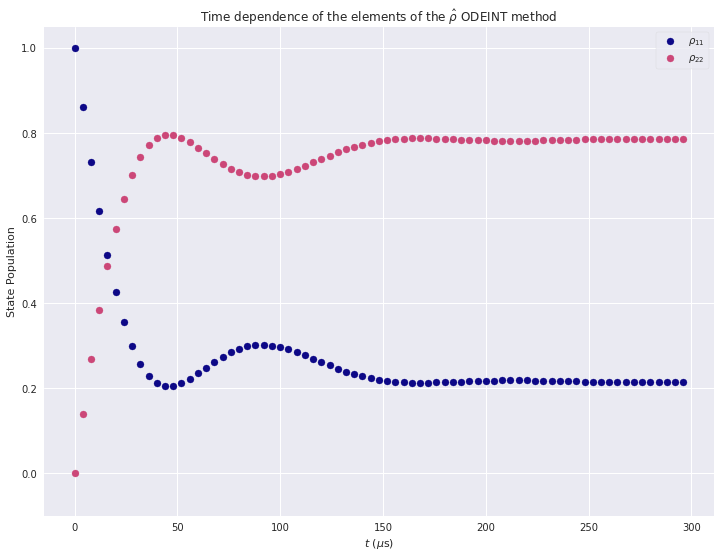

In [61]:
# T1 Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T1Sols = func_t1(xd, *prms_t1)

plt.scatter(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.scatter(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])

plt.title('Time dependence of the elements of the '+r'$\hat{\rho}$'+' ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

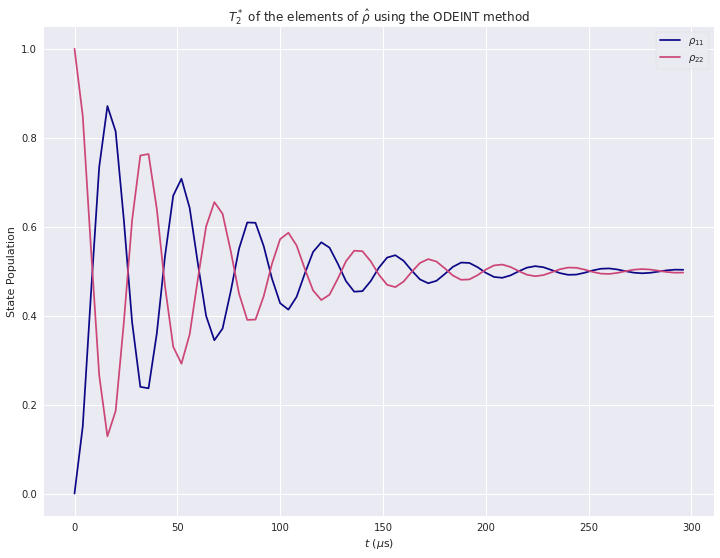

In [62]:
# T2 Star Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

T2sSols = func_t2s(xd, *prms_t2s)

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])

plt.title(r'$T_2^*$' + ' of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

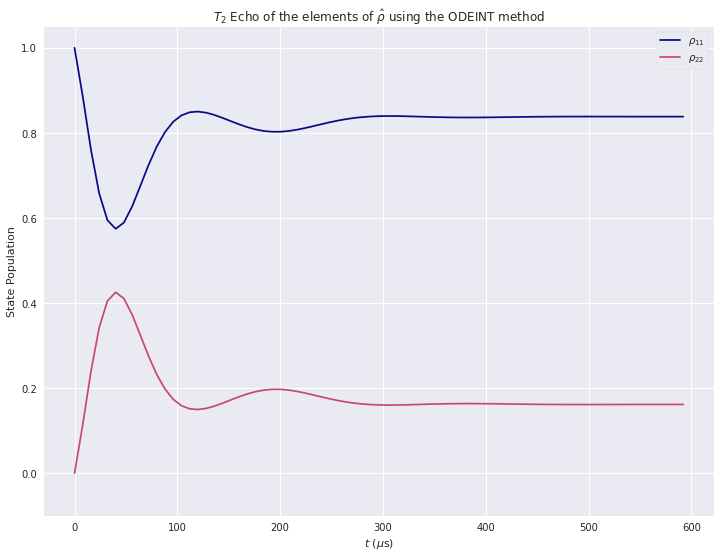

In [63]:
# T2 Echo Solution

%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

# prmsl_hc = jnp.array([g1l[0] * 1e6, g1l[1] * 1e6, j01 * 1e4, n1, n2]) / 1e9

T2eSols = func_t2e(xd * 1.3, *prms_t1)

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])

plt.title(r'$T_2$' + ' Echo of the elements of '+r'$\hat{\rho}$'+' using the ODEINT method')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Compare the device parameters to the experimental results

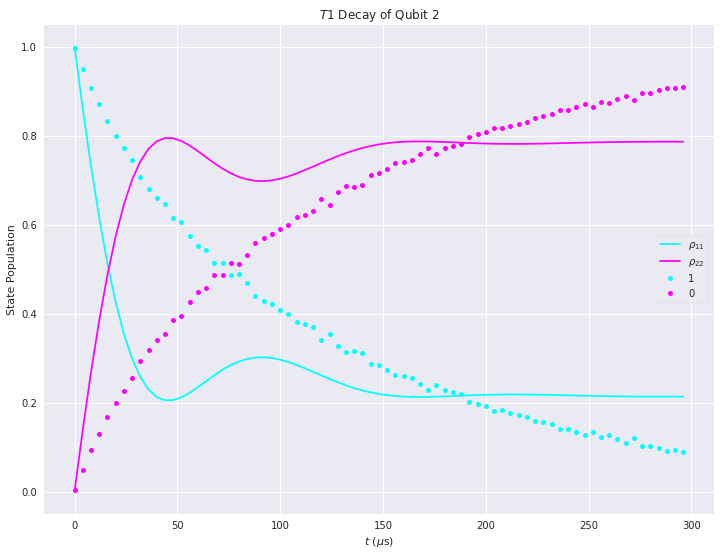

In [64]:
# T1 Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t1mit_lst1, label = "1", marker='.', markersize=10, linestyle='', c = cool[0])
plt.errorbar(time, t1mit_lst0, label = "0", marker='.', markersize=10, linestyle='', c = cool[1])

plt.plot(time, T1Sols[:, 0, 0], label = r'$\rho_{11}$', color = cool[0])
plt.plot(time, T1Sols[:, 1, 1], label = r'$\rho_{22}$', color = cool[1])

plt.title(f'$T1$ Decay of Qubit {qubits[0]}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

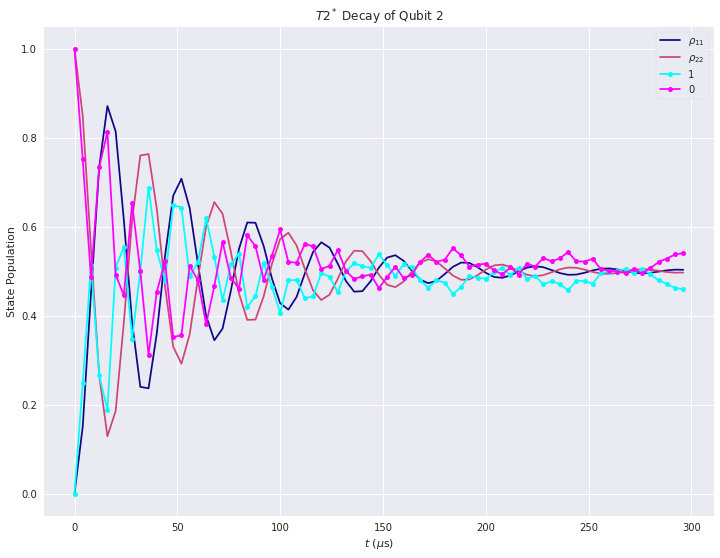

In [65]:
# T2 Star Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.errorbar(time, t2smit_lst1, label = "1", marker='.', markersize=10, c = cool[0])
plt.errorbar(time, t2smit_lst0, label = "0", marker='.', markersize=10, c = cool[1])

plt.plot(time, T2sSols[:, 0, 0], label = r'$\rho_{11}$', color = plasma[0])
plt.plot(time, T2sSols[:, 1, 1], label = r'$\rho_{22}$', color = plasma[1])

plt.title(f'$T2^*$ Decay of Qubit {qubits[0]}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

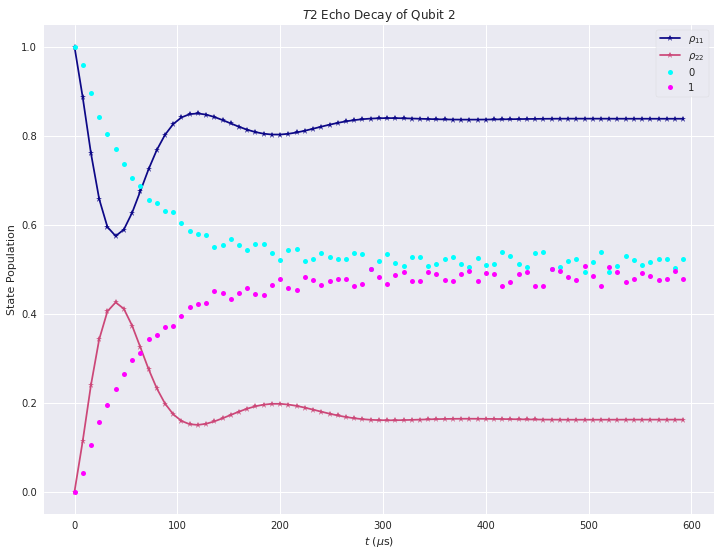

In [66]:
# T2 Echo Solution and Experiments

%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time * 2, T2eSols[:, 0, 0], label = r'$\rho_{11}$', marker='*', color = plasma[0])
plt.plot(time * 2, T2eSols[:, 1, 1], label = r'$\rho_{22}$', marker='*', color = plasma[1])

plt.plot(time * 2, t2emit_lst0, label = "0", marker='.', linestyle = '', markersize=10, c = cool[0])
plt.plot(time * 2, t2emit_lst1, label = "1", marker='.', linestyle = '', markersize=10, c = cool[1])

plt.title(f'$T2$ Echo Decay of Qubit {qubits[0]}')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('State Population')
# plt.ylim(-0.1, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

In [67]:
((xd)[-5:] * unts.ms).to(unts.us) * 0.3

<Quantity [84. , 85.2, 86.4, 87.6, 88.8] us>

## Data Optimisation

In [68]:
# Least Squares Function

def mse(observations, estimates):
    '''
    INPUT:
        observations - numpy array of values indicating observed values
        estimates - numpy array of values indicating an estimate of values
    OUTPUT:
        Mean Square Error value
    '''
    
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return mse

In [69]:
def reg(observations, estimates):
    obav = []
    diff = []
    var = []
    dlen = len(time)
    
    for i in range(N):
        obav.append(sum(observations[i])/dlen)
    
    for d in range(N):
        diff.append(jnp.abs(observations[d] - estimates[d]))
    
    for a in range(N):
        var.append(jnp.abs(observations[a] - obav[a]))
    
    sq_diff = sum(diff) ** 2
    mse = sum(sq_diff)
    vari = sum(sum(var) ** 2)
    r2 = (1 - (mse/vari)) * 100
    
    return r2

In [70]:
# Minimise the LstSqrs Function

def minmse(y):
    Y = y[0]
    
    rhot1 = func_t1(xd, *Y)
    
    t1data = jnp.array(t1mit_lst1, dtype=jnp.float64)
    t2data = jnp.array(t1mit_lst0, dtype=jnp.float64)
    tdata = [t1data, t2data]
    
    tst1 = rhot1[:, 0, 0]
    tst2 = rhot1[:, 1, 1]
    tstd = [tst1, tst2]
    
    return mse(tdata, tstd)

In [71]:
minmse(jnp.array([prms_t1]))

DeviceArray(10.91713, dtype=float32)

In [72]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g1l[0], g1l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack(bound, n_iter, alpha, beta1, beta2, eps=1e-8):
  x = bound
  first = x
  best = x
  worst = x
  score = minfunc(jnp.array([[x]]))
  # score = minmse(jnp.array([x]))
  scbest = score
  print('f(%s) = %f' % (x, score))
  
  J = jacrev(minmse)
  
  m = jnp.zeros(len(prms_t1))
  v = jnp.zeros(len(prms_t1))
  
  for t in range(n_iter + 1):
      # calculate gradient g(t)
      g = J([x])[0]
      
      m = beta1 * m + (1.0 - beta1) * g
      v = beta2 * v + (1.0 - beta2) * g**2
      
      mhat = m / (1.0 - beta1**(t+1))
      vhat = v / (1.0 - beta2**(t+1))
      
      x = x - alpha * mhat / (sqrt(vhat) + eps)
      
      for i in range(len(x)):
          if x[i] < 0:
            #   x = index_update(x, index[i], bound[i])
            # x[i] = bound[i]
            x = x.at[i].set(bound[i])
      
      if scbest > minmse(jnp.array([x])):
          best = x
          scbest = minmse(jnp.array([best]))
      
      # evaluate candidate point
      score = minfunc(jnp.array([[x]]))
      # score = minmse(jnp.array([x]))
      scorelst.append(score)
      tlst.append(t)
      print('>%d => %f' % (t, score))
  return [best, scbest]

In [73]:
# bnds = prms_t1
bnds = jnp.array([0, 0, w0, g1l[0] * 1e6, g1l[1] * 1e6, n1]) / 1e9
# bnds = prmsl_hc

In [74]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best, score = adam_jack(bnds, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best, score))

f([0.0000000e+00 0.0000000e+00 3.0286737e+01 3.5453693e+01 7.5165200e+00
 2.0049516e-16]) = 24.290545
>0 => 11.289156
>1 => 13.135298
>2 => 14.184821
>3 => 14.818696
>4 => 15.225926
>5 => 15.495909
>6 => 15.675673
>7 => 15.792243
>8 => 15.862222
>9 => 15.896273
>10 => 15.901549
>11 => 15.882851
>12 => 15.843496
>13 => 15.785671
>14 => 15.710724
>15 => 15.619349
>16 => 15.511721
>17 => 15.387424
>18 => 15.245615
>19 => 15.084875
>20 => 14.903214
>21 => 14.697992
>22 => 14.465657
>23 => 14.201627
>24 => 13.899872
>25 => 13.552476
>26 => 13.148853
>27 => 12.674721
>28 => 12.110347
>29 => 11.427982
>30 => 10.587802
>31 => 9.531630
>32 => 8.174648
>33 => 6.400912
>34 => 4.105634
>35 => 1.504935
>36 => 0.103692
>37 => 0.482146
>38 => 0.750069
>39 => 0.308136
>40 => 0.162251
>41 => 0.308241
>42 => 0.249588
>43 => 0.146054
>44 => 0.166854
>45 => 0.176616
>46 => 0.130421
>47 => 0.083649
>48 => 0.091109
>49 => 0.121885
>50 => 0.103611
>51 => 0.068197
>52 => 0.070204
>53 => 0.086065
>54 => 0.0832

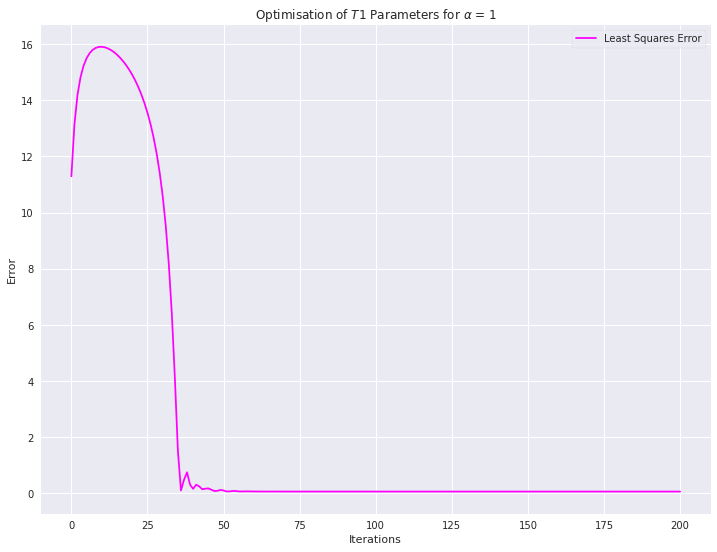

In [75]:
%matplotlib inline
plt.style.use('seaborn')
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(tlst, scorelst, label = 'Least Squares Error', color = cool[1])

plt.title('Optimisation of $T1$ Parameters for ' + r'$\alpha$' + ' = ' + str(alpha))
plt.xlabel('Iterations')
plt.ylabel('Error')
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Plot the fitted results

In [76]:
t1_best = func_t1(xd, *best)

In [77]:
#R2 Regression

np.round(reg([jnp.array(t1mit_lst1, dtype=jnp.float64), jnp.array(t1mit_lst0, dtype=jnp.float64)],
    [t1_best[:, 0, 0], t1_best[:, 1, 1]]), 2)

DeviceArray(99.619995, dtype=float32)

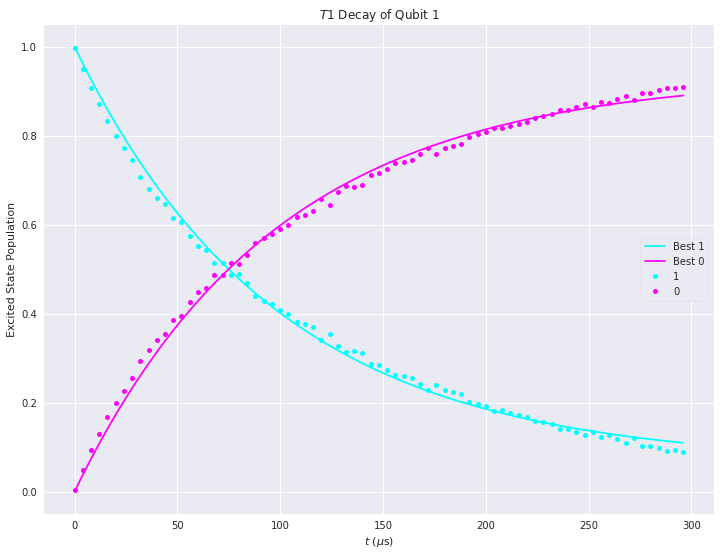

In [78]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

plt.plot(time, t1_best[:, 0, 0], label = 'Best 1', color = cool[0])
plt.plot(time, t1_best[:, 1, 1], label = 'Best 0', color = cool[1])
plt.plot(time, t1mit_lst1, label = '1', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst0, label = '0', marker='.', markersize=10, linestyle='', color = cool[1])

plt.title('$T1$ Decay of Qubit 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

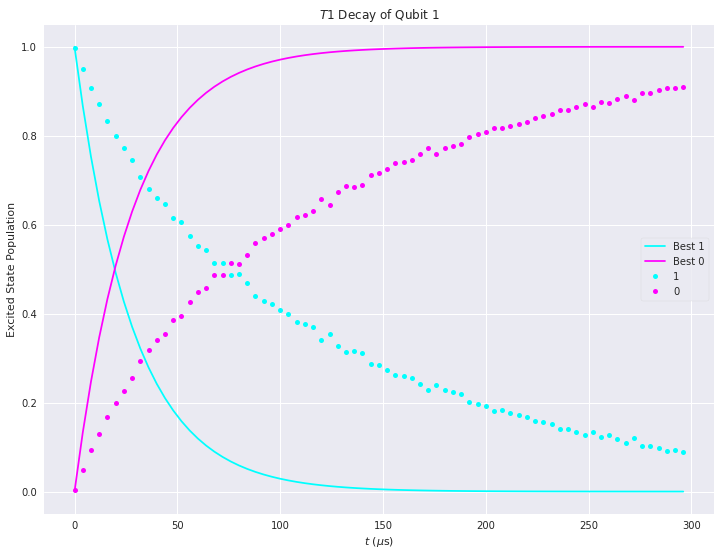

In [79]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(figsize=(12, 9))

pideal = jnp.array([0, 0, w0, g1l[0] * 1e6, g1l[1] * 1e6, n1]) / 1e9

t1_ideal = func_t1(xd, *pideal)

plt.plot(time, t1_ideal[:, 0, 0], label = 'Best 1', color = cool[0])
plt.plot(time, t1_ideal[:, 1, 1], label = 'Best 0', color = cool[1])
plt.plot(time, t1mit_lst1, label = '1', marker='.', markersize=10, linestyle='', color = cool[0])
plt.plot(time, t1mit_lst0, label = '0', marker='.', markersize=10, linestyle='', color = cool[1])

plt.title('$T1$ Decay of Qubit 1')
plt.xlabel('$t$ ($\mu$s)')
plt.ylabel('Excited State Population')
plt.ylim(-0.05, 1.05)
plt.legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Same now for $T_2$ Echo

In [80]:
def minmse2(y):
    Y = y[0]
    
    rhot2e = func_t2e(xd, *Y)
    
    t1data = jnp.array(t2emit_lst0, dtype=jnp.float64)
    t2data = jnp.array(t2emit_lst1, dtype=jnp.float64)
    tdata = [t1data, t2data]
    
    tst1 = rhot2e[:, 0, 0]
    tst2 = rhot2e[:, 1, 1]
    tstd = [tst1, tst2]
    
    return mse(tdata, tstd)

In [81]:
minmse2([prms_t1])

DeviceArray(23.24324, dtype=float32)

In [82]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse2)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g2l[0], g2l[1], j01, n1, n2], dtype = jnp.float32)

def adam_jack2(bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bounds
    first = x
    best = x
    worst = x
    score = minfunc(jnp.array([[x]]))
    scbest = score
    print('f(%s) = %f' % (x, score))
    
    J = jacrev(minmse2)
  
    m = jnp.zeros(len(prms_t1))
    v = jnp.zeros(len(prms_t1))
    
    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]
        
        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2
        
        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))
        
        x = x - alpha * mhat / (sqrt(vhat) + eps)
        
        for i in range(len(x)):
            if x[i] < 0:
                # x = index_update(x, index[i], bounds[i])
                # x[i] = bounds[i]
                x = x.at[i].set(bounds[i])
        
        if scbest > minmse2(jnp.array([x])):
            best = x
            scbest = minmse2(jnp.array([best]))
        
        # evaluate candidate point
        score = minfunc(jnp.array([[x]]))
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest, first]

In [83]:
# bnds2 = best2
# bnds2 = prmsl_hc
bnds2 = jnp.array([0, 0, w0, g1l[0] * 1e6, g1l[1] * 1e6, n1]) / 1e9
# bnds2 = jnp.array([g2l[0] * 1e-3, g2l[1] * 1e-3, j01 * 1e-3, N1, N2])

In [84]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 200
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best2, score2, worst = adam_jack2(bnds2, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best2, score2))

f([0.0000000e+00 0.0000000e+00 3.0286737e+01 3.5453693e+01 7.5165200e+00
 2.0049516e-16]) = 0.916165
>0 => 0.885274
>1 => 0.855466
>2 => 0.826805
>3 => 0.799355
>4 => 0.773170
>5 => 0.748287
>6 => 0.724730
>7 => 0.702487
>8 => 0.681522
>9 => 0.661781
>10 => 0.643194
>11 => 0.625679
>12 => 0.609134
>13 => 0.593448
>14 => 0.578502
>15 => 0.564173
>16 => 0.550343
>17 => 0.536896
>18 => 0.523728
>19 => 0.510747
>20 => 0.497878
>21 => 0.485064
>22 => 0.472261
>23 => 0.459443
>24 => 0.446595
>25 => 0.433715
>26 => 0.420810
>27 => 0.407890
>28 => 0.394973
>29 => 0.382075
>30 => 0.369215
>31 => 0.356411
>32 => 0.343678
>33 => 0.331033
>34 => 0.318491
>35 => 0.306063
>36 => 0.293765
>37 => 0.281607
>38 => 0.269603
>39 => 0.257768
>40 => 0.246115
>41 => 0.234660
>42 => 0.223418
>43 => 0.212406
>44 => 0.201641
>45 => 0.191141
>46 => 0.180921
>47 => 0.171000
>48 => 0.161393
>49 => 0.152117
>50 => 0.143187
>51 => 0.134615
>52 => 0.126416
>53 => 0.118599
>54 => 0.111174
>55 => 0.104148
>56 => 0.0975

0.032400

In [85]:
t2e_best = func_t2e(xd, *best2)

In [86]:
#R2 Regression

np.round(reg([jnp.array(t2emit_lst0, dtype=jnp.float64), jnp.array(t2emit_lst1, dtype=jnp.float64)],
    [t2e_best[:, 0, 0], t2e_best[:, 1, 1]]), 2)

DeviceArray(98.97, dtype=float32)

99.07

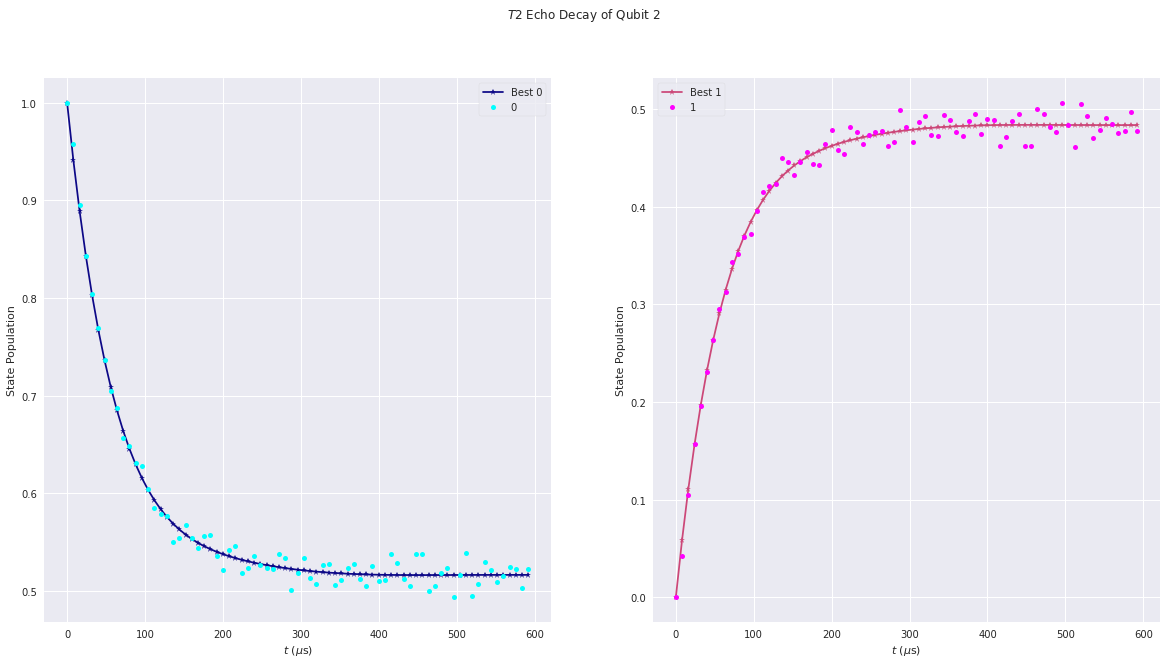

In [87]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# plt.errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# plt.errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# plt.errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# plt.errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# ax[0, 0].errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# ax[0, 1].errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# ax[1, 0].errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# ax[1, 1].errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# plt.plot(time, t2e_best[:, 0, 0], label = 'Best 00', marker='*', color = plasma[0])
# plt.plot(time, t2e_best[:, 1, 1], label = 'Best 10', marker='*', color = plasma[1])
# plt.plot(time, t2e_best[:, 2, 2], label = 'Best 01', marker='*', color = plasma[2])
# plt.plot(time, t2e_best[:, 3, 3], label = 'Best 11', marker='*', color = plasma[3])

ax[0].plot(time * 2, t2e_best[:, 0, 0], label = 'Best 0', marker='*', color = plasma[0])
ax[1].plot(time * 2, t2e_best[:, 1, 1], label = 'Best 1', marker='*', color = plasma[1])

ax[0].plot(time * 2, t2emit_lst0, label = "0", marker='.', linestyle = '', markersize=10, c = cool[0])
ax[1].plot(time * 2, t2emit_lst1, label = "1", marker='.', linestyle = '', markersize=10, c = cool[1])

fig.suptitle(f'$T2$ Echo Decay of Qubit {qubits[0]}')

for a in ax.flat:
    a.set(xlabel='$t$ ($\mu$s)', ylabel='State Population')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for b in ax.flat:
#     b.label_outer()

# fig.xlabel('$t$ ($\mu$s)')
# fig.ylabel('Excited State Population')
# plt.ylim(-0.05, 1.05)

ax[0].legend(loc = "best",numpoints=1,frameon=True)
ax[1].legend(loc = "best",numpoints=1,frameon=True)

plt.show()

## Same now for $T_2^*$

In [88]:
def minmse2s(y):
    Y = y[0]
    
    rhot2s = func_t2s(xd, *Y)
    
    t1data = jnp.array(t2smit_lst1, dtype=jnp.float64)
    t2data = jnp.array(t2smit_lst0, dtype=jnp.float64)
    tdata = [t1data, t2data]
    
    tst1 = rhot2s[:, 0, 0]
    tst2 = rhot2s[:, 1, 1]
    tstd = [tst1, tst2]
    
    return mse(tdata, tstd)

In [89]:
minmse2s([prms_t2s])

DeviceArray(5.4356775, dtype=float32)

In [90]:
# Define an adam gradient descent optimiser

minfunc = vmap(minmse2s)

scorelst = []
tlst = []

# bounds = jnp.array([w0, w1, g2l[0], g2l[1], j01, n1, n2], dtype = jnp.float32)


def adam_jack2(bounds, n_iter, alpha, beta1, beta2, eps=1e-8):
    x = bounds
    first = x
    best = x
    worst = x
    score = minfunc(jnp.array([[x]]))
    scbest = score
    print('f(%s) = %f' % (x, score))

    J = jacrev(minmse2s)

    m = jnp.zeros(len(prms_t1))
    v = jnp.zeros(len(prms_t1))

    for t in range(n_iter + 1):
        # calculate gradient g(t)
        g = J([x])[0]

        m = beta1 * m + (1.0 - beta1) * g
        v = beta2 * v + (1.0 - beta2) * g**2

        mhat = m / (1.0 - beta1**(t+1))
        vhat = v / (1.0 - beta2**(t+1))

        x = x - alpha * mhat / (sqrt(vhat) + eps)

        for i in range(len(x)):
            if x[i] < 0:
                # x = index_update(x, index[i], bounds[i])
                # x[i] = bounds[i]
                x = x.at[i].set(bounds[i])

        if scbest > minmse2s(jnp.array([x])):
            best = x
            scbest = minmse2s(jnp.array([best]))

        # evaluate candidate point
        score = minfunc(jnp.array([[x]]))
        scorelst.append(score)
        tlst.append(t)
        print('>%d => %f' % (t, score))
    return [best, scbest, first]

In [91]:
# bnds2 = best2s
# bnds2 = prmsl_hc
# bnds2 = jnp.array([w0/2, w0/2, w0/2, g2l[0] * 1e6, 1e9, n1]) / 1e9
bnds2 = prms_t2s
# bnds2 = jnp.array([g2l[0] * 1e-3, g2l[1] * 1e-3, j01 * 1e-3, N1, N2])

In [92]:
# Run the gradient descent algorithm

# define the total iterations
n_iter = 1000
# steps size
alpha = 0.1
# factor for average gradient
beta1 = 0.8
# factor for average squared gradient
beta2 = 0.999
# perform the gradient descent search with adam
best2s, score2s, worsts = adam_jack2(bnds2, n_iter, alpha, beta1, beta2)
print('Done!')
print('f(%s) = %f' % (best2s, score2s))

f([0.0000000e+00 0.0000000e+00 1.8172041e+02 3.3737682e+01 0.0000000e+00
 2.0049516e-16]) = 5.435678
>0 => 4.733705
>1 => 4.245880
>2 => 3.888481
>3 => 3.615764
>4 => 3.400952
>5 => 3.227407
>6 => 3.084294
>7 => 2.964241
>8 => 2.862061
>9 => 2.774011
>10 => 2.697293
>11 => 2.629802
>12 => 2.569905
>13 => 2.516325
>14 => 2.468049
>15 => 2.424265
>16 => 2.384308
>17 => 2.347643
>18 => 2.313823
>19 => 2.282477
>20 => 2.253303
>21 => 2.226038
>22 => 2.200466
>23 => 2.176403
>24 => 2.153690
>25 => 2.132193
>26 => 2.111797
>27 => 2.092400
>28 => 2.073918
>29 => 2.056273
>30 => 2.039400
>31 => 2.023241
>32 => 2.007740
>33 => 1.992861
>34 => 1.978553
>35 => 1.964785
>36 => 1.951522
>37 => 1.938735
>38 => 1.926397
>39 => 1.914483
>40 => 1.902972
>41 => 1.891841
>42 => 1.881073
>43 => 1.870649
>44 => 1.860555
>45 => 1.850773
>46 => 1.841290
>47 => 1.832093
>48 => 1.823171
>49 => 1.814510
>50 => 1.806101
>51 => 1.797934
>52 => 1.789997
>53 => 1.782284
>54 => 1.774784
>55 => 1.767491
>56 => 1.7603

0.216356

In [93]:
t2s_best = func_t2s(xd, *best2s)

In [94]:
#R2 Regression

np.round(reg([jnp.array(t2smit_lst1, dtype=jnp.float64), jnp.array(t2smit_lst0, dtype=jnp.float64)],
             [t2s_best[:, 0, 0], t2s_best[:, 1, 1]]), 2)

DeviceArray(44.1, dtype=float32)

93.99

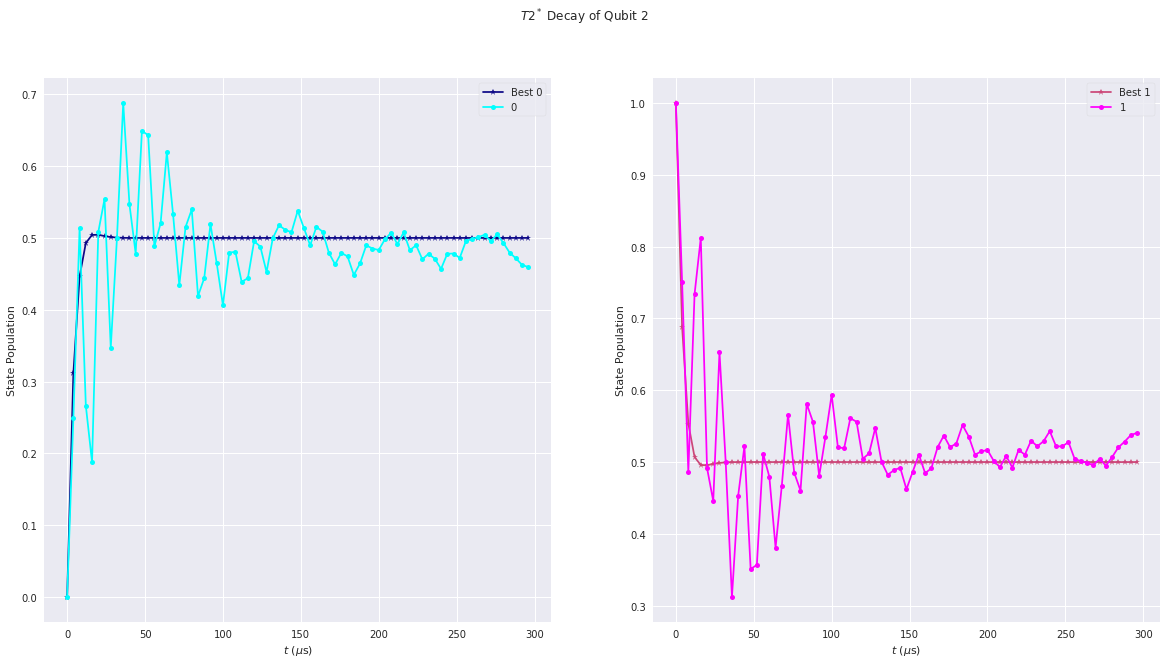

In [95]:
%matplotlib inline
plt.style.use('seaborn')
# matplotlib.rcParams.update({'font.size': 16,'font.family':'serif'})
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

# plt.errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# plt.errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# plt.errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# plt.errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# ax[0, 0].errorbar(time, t2emit_lst00, t1ystd00, label = "00", marker='.', linestyle = '', markersize=10, c = cool[0])
# ax[0, 1].errorbar(time, t2emit_lst10, t1ystd10, label = "10", marker='.', linestyle = '', markersize=10, c = cool[1])
# ax[1, 0].errorbar(time, t2emit_lst01, t1ystd01, label = "01", marker='.', linestyle = '', markersize=10, c = cool[2])
# ax[1, 1].errorbar(time, t2emit_lst11, t1ystd11, label = "11", marker='.', linestyle = '', markersize=10, c = cool[3])

# plt.plot(time, t2e_best[:, 0, 0], label = 'Best 00', marker='*', color = plasma[0])
# plt.plot(time, t2e_best[:, 1, 1], label = 'Best 10', marker='*', color = plasma[1])
# plt.plot(time, t2e_best[:, 2, 2], label = 'Best 01', marker='*', color = plasma[2])
# plt.plot(time, t2e_best[:, 3, 3], label = 'Best 11', marker='*', color = plasma[3])

ax[0].plot(time, t2s_best[:, 0, 0],
           label='Best 0', marker='*', color=plasma[0])
ax[1].plot(time, t2s_best[:, 1, 1],
           label='Best 1', marker='*', color=plasma[1])

ax[0].plot(time, t2smit_lst1, label="0", marker='.', markersize=10, c=cool[0])
ax[1].plot(time, t2smit_lst0, label="1", marker='.', markersize=10, c=cool[1])

fig.suptitle(f'$T2^*$ Decay of Qubit {qubits[0]}')

for a in ax.flat:
    a.set(xlabel='$t$ ($\mu$s)', ylabel='State Population')

# Hide x labels and tick labels for top plots and y ticks for right plots.
# for b in ax.flat:
#     b.label_outer()

# fig.xlabel('$t$ ($\mu$s)')
# fig.ylabel('Excited State Population')
# plt.ylim(-0.05, 1.05)

ax[0].legend(loc="best", numpoints=1, frameon=True)
ax[1].legend(loc="best", numpoints=1, frameon=True)

plt.show()

In [96]:
# import csv

# rows_t2s_1 = zip(time, jnp.real(t2s_best[:, 0, 0]))
# rows_t2s_0 = zip(time, jnp.real(t2s_best[:, 1, 1]))

# with open('Q1_T2s_best1.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2s_1:
#         writer.writerow(row)

# with open('Q1_T2s_best0.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2s_0:
#         writer.writerow(row)


In [97]:
# rows_t2s_1 = zip(time, t2smit_lst1)
# rows_t2s_0 = zip(time, t2smit_lst0)

# with open('Q1_T2s_raw1.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2s_1:
#         writer.writerow(row)

# with open('Q1_T2s_raw0.csv', "w") as a:
#     writer = csv.writer(a)
#     for row in rows_t2s_0:
#         writer.writerow(row)


## Extract Parameters

In [98]:
best

DeviceArray([ 0.        ,  0.        , 30.286737  ,  8.893611  ,
              7.51652   ,  0.07309552], dtype=float32)

In [99]:
wx, wy, wz, gam1, gamz, phon = best

wa = np.average([wx, wy, wz])

Tx = T(wx * 1e9, phon).to(unts.mK)
Ty = T(wy * 1e9, phon).to(unts.mK)
Tz = T(wz * 1e9, phon).to(unts.mK)
Ta = T(wa * 1e9, phon).to(unts.mK)

T1time = 1/gam1 * unts.ms
zz = 1/gamz * unts.ms

In [100]:
jnp.array([wx, wy, wz]) * unts.GHz

<Quantity [ 0.      ,  0.      , 30.286737] GHz>

In [101]:
wa * unts.GHz

<Quantity 10.095579 GHz>

In [102]:
(w0 * unts.Hz).to(unts.GHz)

<Quantity 30.28673663 GHz>

In [103]:
Tx

<Quantity 0. mK>

In [104]:
Ty

<Quantity 0. mK>

In [105]:
Tz

<Quantity 86.10982448 mK>

In [106]:
Ta

<Quantity 28.70327607 mK>

In [107]:
T1time.to(unts.us)

<Quantity 112.44026572 us>

In [108]:
(t1c[qubits[0]] * unts.s).to(unts.us)

<Quantity 163.85155322 us>

In [109]:
zz.to(unts.us)

<Quantity 133.04029405 us>

In [110]:
best2

DeviceArray([1.3259788e+00, 1.1348389e-01, 3.6103058e+01, 2.8553326e+01,
             6.8318099e-01, 2.0049516e-16], dtype=float32)

In [111]:
# Now for T2 Echo

wx2, wy2, wz2, gam12, gamz2, phon2 = best2

wa2 = np.average([wx2, wy2, wz2])

Tx2 = T(wx2 * 1e9, phon2).to(unts.mK)
Ty2 = T(wy2 * 1e9, phon2).to(unts.mK)
Tz2 = T(wz2 * 1e9, phon2).to(unts.mK)
Ta2 = T(wa2 * 1e9, phon2).to(unts.mK)

T2time = 1/gam12 * unts.ms
zz2 = 1/gamz2 * unts.ms

In [112]:
Tz2

<Quantity 7.62921246 mK>

28.348519 mK

In [113]:
Ta2

<Quantity 2.6444653 mK>

9.4825495 mK

In [114]:
T2time.to(unts.us)

<Quantity 35.0221917 us>

34.451887 us

In [115]:
(t2c[qubits[0]] * unts.s).to(unts.us)

<Quantity 65.8400968 us>

65.840097 us

In [116]:
zz2.to(unts.us)

<Quantity 1463.74094486 us>

896.08669 us

In [117]:
# Now for T2*

wx2, wy2, wz2, gam12s, gamz2s, phon2 = best2s

wa2 = np.average([wx2, wy2, wz2])

Tx2 = T(wx2 * 1e9, phon2).to(unts.mK)
Ty2 = T(wy2 * 1e9, phon2).to(unts.mK)
Tz2 = T(wz2 * 1e9, phon2).to(unts.mK)
Ta2 = T(wa2 * 1e9, phon2).to(unts.mK)

T2stime = 1/gam12s * unts.ms
zz2s = 1/gamz2s * unts.ms


In [118]:
Tz2

<Quantity 4120.36800385 mK>

982.53214 mK

In [119]:
Ta2

<Quantity 1373.45600128 mK>

327.51071 mK

In [120]:
T2stime.to(unts.us)

<Quantity 22.55459689 us>

29.835142 us

In [121]:
(t2c[qubits[0]] * unts.s).to(unts.us)

<Quantity 65.8400968 us>

65.840097 us

In [122]:
zz2s.to(unts.us)

<Quantity 261.37951016 us>

5681.6516 us

In [123]:
import qiskit.tools.jupyter
%qiskit_version_table